In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

In [4]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        # 배치 x 1크기의 레이블 텐서==>배치 x 10의 연속적인 텐서로 전환
        # 매번 똑같은 레이블은 항상 똑같은 텐서를 만들기 때문에, 단순히 연속적인 텐서를 레이블 값에 맵핑하기 위함.
        # (연속적인 값이 학습에 더 유용)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),#inplace=True 인자 : 입력을 복사하지 않고, 바로 조작
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),# 레이블이 추가 되었으니, layer를 한 층 더 늘려 조금 더 복잡하게 구현
            nn.Tanh() #이미지 tensor는 -1 ~ 1 사이의 값을 대부분 가짐 그래서 generator 또한 사이 값을 가지게 하기 위해서 tanh를 사용
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)#1차원에 대하여 이어 붙이겠다.
        return self.model(x)

In [5]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        # 배치 x 1크기의 레이블 텐서==>배치 x 10의 연속적인 텐서로 전환
        # 매번 똑같은 레이블은 항상 똑같은 텐서를 만들기 때문에, 단순히 연속적인 텐서를 레이블 값에 맵핑하기 위함.
        # (연속적인 값이 학습에 더 유용)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),# 레이블 정보를 전달하기 위해 이미지 크기(784)에 10
            nn.LeakyReLU(0.2, inplace=True),#판별자에게도 794노드에서 1024노드를 출력하는 계층 하나와 
            nn.Dropout(0.3), #성능을 늘리기 위해 드롭아웃 계층을 2개 더 추가
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()#Sigmoid() 함수를 거쳐 각각 가짜와 진짜를 뜻하는 0,1 사이를 반환
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [6]:
z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
# g_label= torch.randint로 0과 10 사이의 값을 가진 배치x 1 크기의 텐서
g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)


In [7]:
# 모델의 가중치를 지정한 장치로 보내기
# CUDA(GPU) / CPU
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002,betas=(0.5,0.999))

In [8]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        # g_label= torch.randint로 0과 10 사이의 값을 가진 배치x 1 크기의 텐서
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)# z와 g_label관 관계성을 Generator가 학습하도록 한다.
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('Epoch [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

Epoch [0/500] d_loss:1.8279 g_loss: 0.3900 D(x):0.66 D(G(z)):0.74
Epoch [1/500] d_loss:0.3910 g_loss: 2.9814 D(x):0.79 D(G(z)):0.13
Epoch [2/500] d_loss:0.9049 g_loss: 2.2390 D(x):0.70 D(G(z)):0.20
Epoch [3/500] d_loss:0.2961 g_loss: 5.1302 D(x):0.87 D(G(z)):0.06
Epoch [4/500] d_loss:0.3487 g_loss: 3.5438 D(x):0.87 D(G(z)):0.05
Epoch [5/500] d_loss:0.3821 g_loss: 3.6325 D(x):0.92 D(G(z)):0.17
Epoch [6/500] d_loss:0.4941 g_loss: 3.5142 D(x):0.85 D(G(z)):0.18
Epoch [7/500] d_loss:0.5197 g_loss: 2.8732 D(x):0.87 D(G(z)):0.25
Epoch [8/500] d_loss:0.4041 g_loss: 3.4681 D(x):0.89 D(G(z)):0.11
Epoch [9/500] d_loss:0.5598 g_loss: 2.6955 D(x):0.83 D(G(z)):0.19
Epoch [10/500] d_loss:0.4605 g_loss: 2.9838 D(x):0.83 D(G(z)):0.14
Epoch [11/500] d_loss:0.8134 g_loss: 1.6809 D(x):0.78 D(G(z)):0.30
Epoch [12/500] d_loss:0.4716 g_loss: 2.8864 D(x):0.83 D(G(z)):0.16
Epoch [13/500] d_loss:0.9415 g_loss: 1.6756 D(x):0.76 D(G(z)):0.29
Epoch [14/500] d_loss:0.7740 g_loss: 1.8555 D(x):0.78 D(G(z)):0.31
Epoch

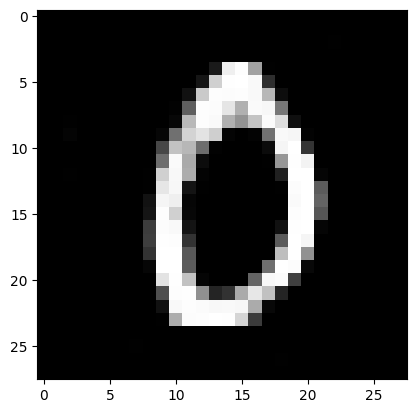

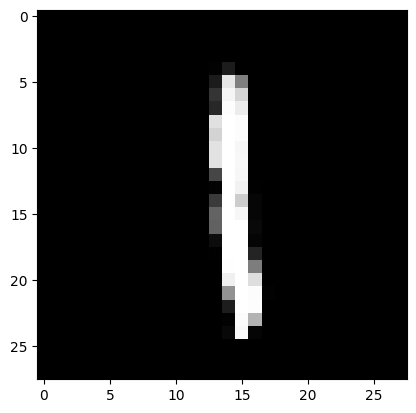

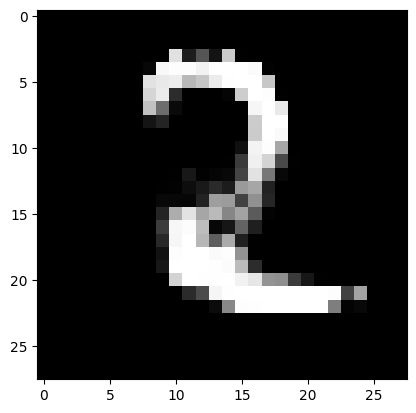

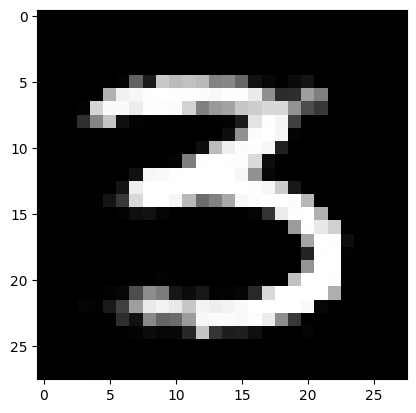

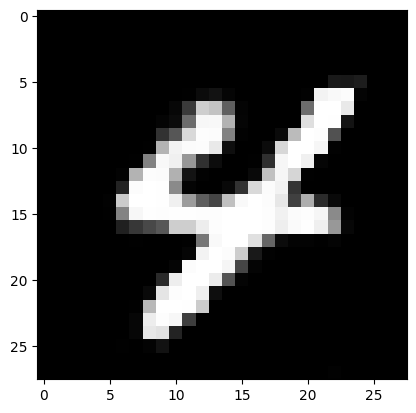

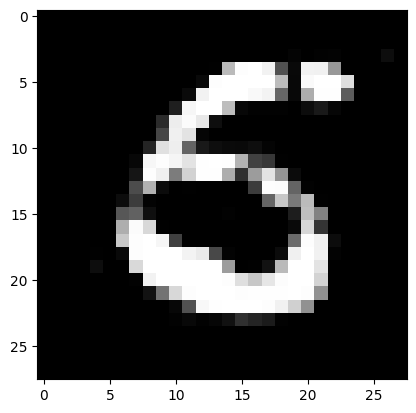

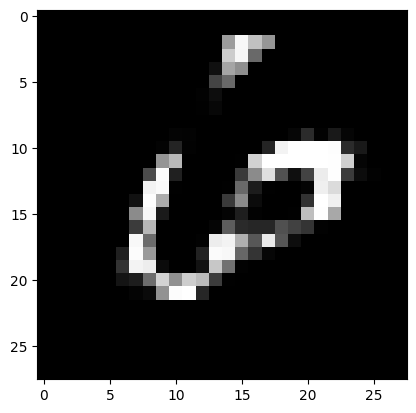

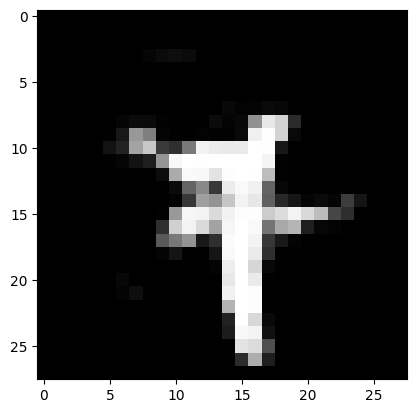

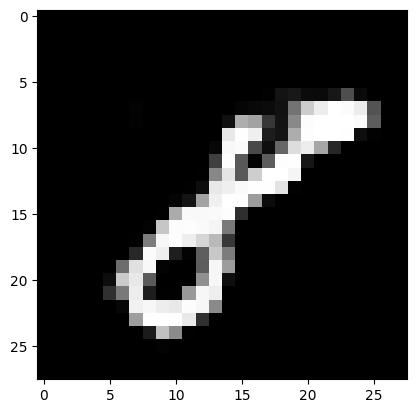

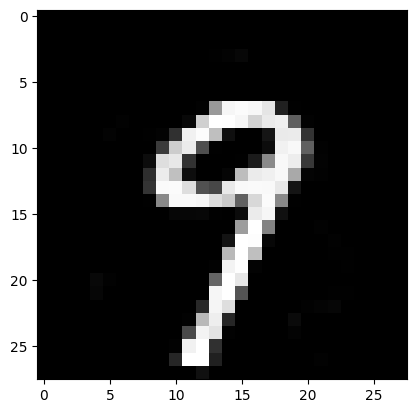

In [19]:
# 만들고 싶은 숫자 생성하고 시각화하기
for i in range(10):
    item_number = i # 숫자 번호
    z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
    g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
    sample_images = G(z, g_label)

    sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                                [0],(28, 28))
    plt.imshow(sample_images_img, cmap = 'gray')
    plt.show()